## Credit card fraud detection with Random Forest 

In the age of technology, the concern with information security is increasingly latent and one of the sectors that seek to improve fraud prevention is credit cards. In 2018, according to [Shift](https://shiftprocessing.com/credit-card-fraud-statistics/), $ 24.26 billion was lost due to payment cards worldwide, and that year in the United States, it led as the country most prone to credit fraud, with 38.6% of those cashed for card fraud.

Here, in this project, we will **predict a credit card fraud** using the dataset [```creditcardfraud```](https://www.kaggle.com/mlg-ulb/creditcardfraud), wich has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.

![](https://i.imgur.com/GOkWs2N.png)

The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

## General setup

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [3]:
plt.style.use('ggplot')
sns.set_style('whitegrid', {'axes.spines.left': True,
                            'axes.spines.bottom': True,
                            'axes.spines.right': True,
                            'axes.spines.top': True})

In [4]:
df = pd.read_csv('creditcard.csv')

## A brief exploratory data analysis

First, let's take a overview of our dataset.

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


As previously mentioned, most variables here are the result of a PCA process and, therefore, it is difficult to make a deep exploratory analysis of the variables, since they do not have an explicit meaning.

However, we have two non-standard variables that have not gone through this process to analyze and we can also see the behavior of the distribution in each class of the values of the processed variables.

Let's check out the two that haven't gone through the PCA first. 

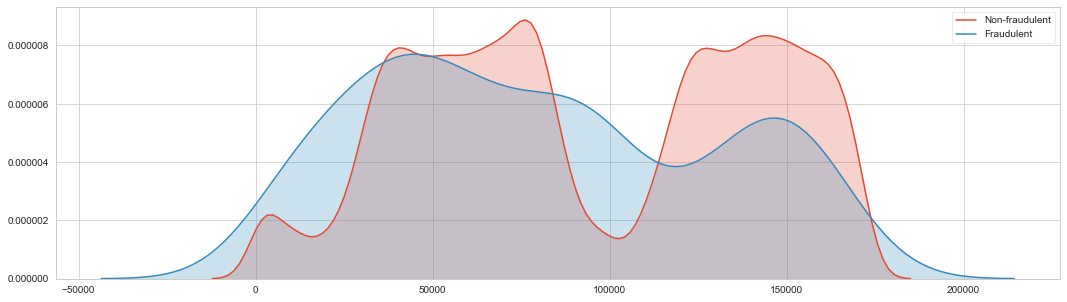

In [6]:
fig, ax = plt.subplots(figsize=(18, 5))

sns.kdeplot(df.query('Class==0').Time, ax=ax, shade=True, label='Non-fraudulent')
sns.kdeplot(df.query('Class==1').Time, ax=ax, shade=True, label='Fraudulent')

plt.show()

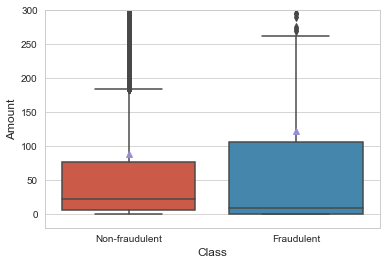

In [7]:
fig, ax = plt.subplots()

sns.boxplot(df.Class, df.Amount, showmeans=True, ax=ax)
plt.ylim((-20, 300))
plt.xticks([0, 1], ['Non-fraudulent', 'Fraudulent'])

plt.show()

A priori, there is no useful correlation between the time or amount of the transation and the status of fraudulent or non-fraudulent.

That done, let's look at the behavior of the variables that went through the PCA process.

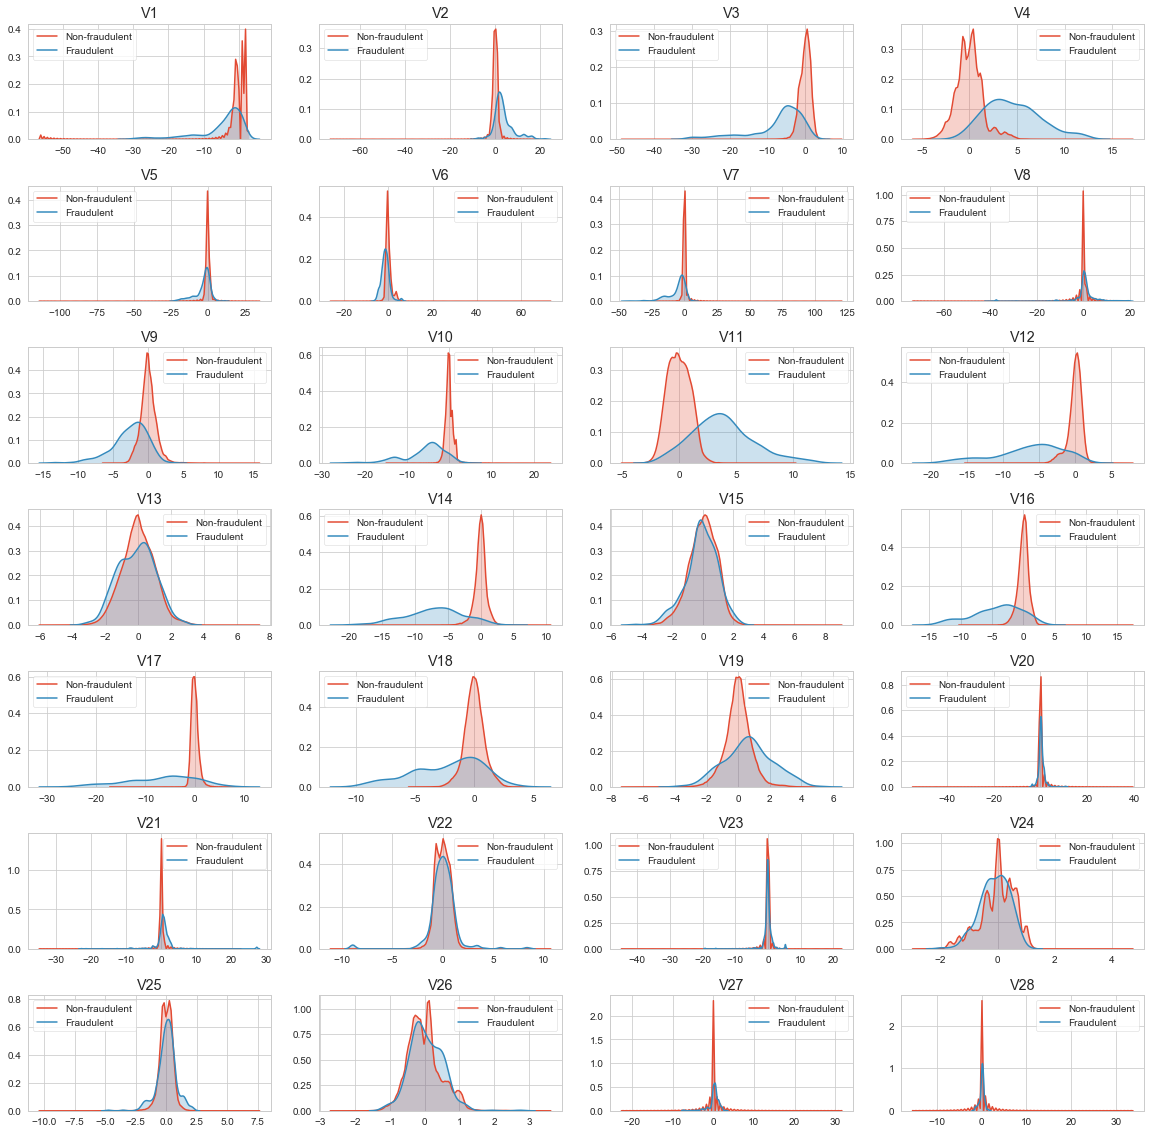

In [8]:
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(20,20))
fig.subplots_adjust(hspace=0.4)

for i, col in enumerate(df.iloc[:,1:-2].columns):
    sns.kdeplot(df.query('Class == 0')[col], label="Non-fraudulent", shade=True, ax=axes[i//4,i%4])
    sns.kdeplot(df.query('Class == 1')[col], label="Fraudulent", shade=True, ax=axes[i//4,i%4])
    axes[i//4,i%4].set_title(col)

## Data Processing

The first stage of data processing would normally be to standardize variables, deal with missing values or do other manipulations. However, this dataset does not require these activities to be performed and, therefore, we will start by separating X and y, X being the set of independent variables and y being the dependent variable, which we will try to predict successfully.

In [45]:
X = df.drop(columns=['Class', 'Amount', 'Time'])
y = df.Class

In this case, we are dealing with an imbalanced data problem and, therefore, we need to work around this problem in some way. There are several techniques that could be used, but here we will choose SMOTE - Synthetic Minority Oversampling Technique. 

According with the book Imbalanced Learning: Foundations, Algorithms, and Applications, 2013:
>_"SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b."_

The following picture shows how oversampling works in general:
![image.png](https://miro.medium.com/max/750/1*aKJJOozIlVVH1gT-4rYy4w.png)

A common mistake when applying a technique to solve the imbalance problem is to apply both to the training set and the test set.  But there is the problem that in doing so, we would be using synthetic data to evaluate the model, which does not make sense because it don't represent reality.

The right way to solve this issue is apply these techniques only in the train dataset, preserving the test data. Thus, let's first use train_test_split and later apply the SMOTE in the training portion.

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

In [39]:
smote = SMOTE()

X_balanced, y_balanced = smote.fit_resample(X_train, y_train)

Now, we can check the previous and the current distribution:

In [40]:
print(f'Previous distribution of target values: \n{y_train.value_counts()} \n')
print(f'Distribution of targer values after applying SMOTE: \n{y_balanced.value_counts()}')

Previous distribution of target values: 
0    227450
1       395
Name: Class, dtype: int64 

Distribution of targer values after applying SMOTE: 
1    227450
0    227450
Name: Class, dtype: int64


As can be seen, our mission was successfully accomplished and now we have a **balanced data**.

 ## Machine Learning

Classification problems are a recurring problem in Machine Learning and there are several different approaches. Here, we will choose to use an ensemble algorithm known as Random Forest. But... What is the reason for this choice?

Well, the Random Forest is an ensemble of Decision Trees, generally trained via the bagging methodd and this algorithm have some benefits: 
 * Introduces extra randomness when growing trees; 
 * Instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features.

The algorithm results in greater tree diversity, which (again) trades a higher bias for a lower variance, generally yielding an overall better model.

Reference: Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow (2019, O’reilly) 
    

So, let's train our model and generate the predictions.

In [41]:
rf_clf = RandomForestClassifier(random_state=777)

rf_clf.fit(X_balanced, y_balanced)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=777,
                       verbose=0, warm_start=False)

In [42]:
y_pred = rf_clf.predict(X_test)

Done that, we can proceed to evaluation. 

First, let's use the classification_report and see the metrics for accuracy, recall and F1-score.

In [43]:
print('Classification Report:\n', classification_report(y_test,y_pred, digits=4))

Classification Report:
               precision    recall  f1-score   support

           0     0.9998    0.9999    0.9998     56865
           1     0.9130    0.8660    0.8889        97

    accuracy                         0.9996     56962
   macro avg     0.9564    0.9329    0.9444     56962
weighted avg     0.9996    0.9996    0.9996     56962



Another common mistake when dealing with unbalanced data problems is to use the avg macro of these metrics in isolation. This can give you the false feeling that your model is working well when in fact it is not. See the following example:

> If there are 100 houses and we want to classify them into small and large, assuming that only 10 of them are small and our model classifies them all as large, it would still have an precision of 0.9 but no house was classified as small, showing that something is wrong.

Therefore, a better way to visualize the results is through the confusion matrix. Let's plot it.

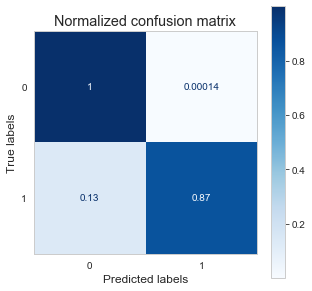

In [44]:
fig, ax = plt.subplots(figsize=(5, 5))

plot_confusion_matrix(rf_clf, X_test, y_test,
                      cmap=plt.cm.Blues,
                      normalize='true',
                      
                      ax=ax)

ax.grid(b=None)
ax.set_title('Normalized confusion matrix')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

plt.show()

Through this chart, we can see that we were able to **predict 87% of cases** where there would be fraud in the transaction, which in turn would represent a huge savings for the company.

Another interesting way to view the results of a classification is from the Receiver Operant Curve(ROC). It graphically shows the relationship between the true positive rate (TPR) and the false positive rate (FPR). 

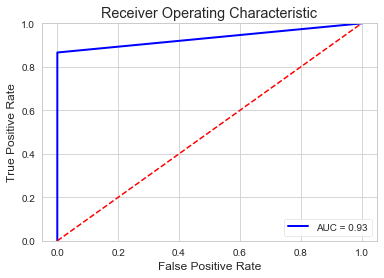

In [17]:
# Plot ROC curve
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
                       
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc,  linewidth=2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

 ## Feature Importance
 
An important task when carrying out supervised learning on a high dimensional data set is to determine which set of features provides the best predictive power with the least possible computational cost. Let's check what the importance of each feature and select the most important ones to train again our model.

In [18]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_clf.feature_importances_), 
                                   columns=['feature', 'score']).sort_values(by='score', ascending=False) 

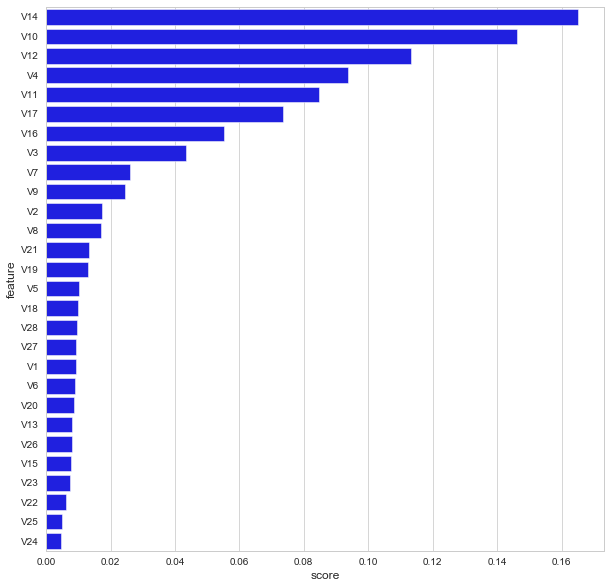

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x=feature_importances.score, 
            y=feature_importances.feature, color='blue', orient='h')
plt.show()

By selecting the top 10 features, we reduce in about 75% the dimensionality of our train dataset. 

Now, let's fit and predict again and check the new perfomance.

In [20]:
rf_clf = RandomForestClassifier(random_state=777)

rf_clf.fit(X_balanced[feature_importances.feature[:10]], y_balanced)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=777,
                       verbose=0, warm_start=False)

In [21]:
y_pred = rf_clf.predict(X_test[feature_importances.feature[:10]])

In [22]:
print('Classification Report:\n', classification_report(y_test,y_pred, digits=4))

Classification Report:
               precision    recall  f1-score   support

           0     0.9998    0.9997    0.9997     56865
           1     0.8190    0.8866    0.8515        97

    accuracy                         0.9995     56962
   macro avg     0.9094    0.9431    0.9256     56962
weighted avg     0.9995    0.9995    0.9995     56962



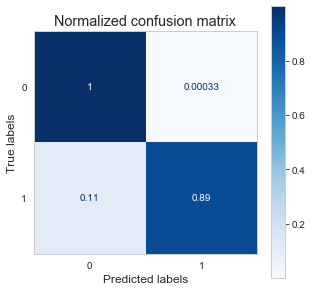

In [23]:
fig, ax = plt.subplots(figsize=(5, 5))

plot_confusion_matrix(rf_clf, X_test[feature_importances.feature[:10]], y_test,
                      cmap=plt.cm.Blues,
                      normalize='true',
                      ax=ax)

ax.grid(b=None)
ax.set_title('Normalized confusion matrix')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

plt.show()

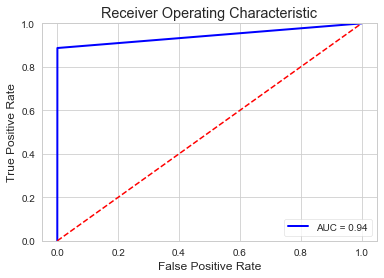

In [24]:
# Plot ROC curve
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
                       
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc,  linewidth=2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Let's do a recap and compare the results.

|                          | PRECISION | RECALL | F1 SCORE | AUC  |
|--------------------------|-----------|--------|----------|------|
| All features             | 0.9614    | 0.9329 | 0.9467   | 0.93 |
| Most important features  | 0.9018    | 0.9431 | 0.9214   | 0.94 |

As can be seen, we had a small improvement in the performance of some metrics and a worsening in others. Furthermore, as we can see in the confusion matrix, we are now able to correctly predict 89% of fraud cases instead of the 87% predicted previously but we mistakenly classify 0.033% of cases as fraud, compared to the former 0.14%.

These trade-offs do not necessarily make one model better than the other, they just make them different. 

What is better? 
* To be able to identify more fraud but at the cost of misclassifying some more transactions
* To be able to identify less fraud but to prevent some transactions from being mistakenly classified as fraud

The choice would be dependent on the company's business strategy.

 ## Conclusion

First of all, it is important to mention that the ideal would be to test a group of algorithms and to perform a process of tuning hyperparameters using RandomSearch or Bayesian Optimization, but for this specific project we choosen just to run the Random Forest with the standard definitions, which has already performed well. 

Now, about the project itself, we can see that it was a project where we exercised different concepts and the main one was the way of dealing with imbalanced data. Also, we also exercise the different assessment metrics for classification problems and the advantages and limitations of each one. 